In [1]:
%run setup
%load_ext autoreload
%autoreload 2

In [163]:
from IPython.display import Image
from pathlib import Path
from nlp_intro.data import draw_uniform_data
from nlp_intro.figure_factory import Linear2D2ClassModelPlotter, plot_3d_scatter, gradient_descent_animation, plot_as_image
import pandas as pd
import numpy as np
from nlp_intro.logistic_regression import gradient
from nlp_intro.data import load_diskusjon_no_data
from nlp_intro.my_multiprocessing import process
import warnings
import re

In [171]:
warnings.filterwarnings("ignore")

In [3]:
root_dir = Path("..").resolve()

# Motivasjon

- Store deler av mennneskehetens samlede kunnskap finnes i tekstlige, ikke-strukturerte dokumenter
    - Et *dokument* kan være alt fra en tweet til en hel vitnekapelig artikkel, avhengig av problemet du prøver å løse
- Mer tekstdata genereres hver dag enn én person kan rekke å lese hele sitt liv
- Mange virkelige datasett er delvis tekst, og disse teknikkene kan brukes for å hente ut "featres" fra denne teksten

Og ikke minst: om vi noen gang skal ha håp om å kommunisere med datamaskiner må vi gjøre dem i stand til å forstå språket vi bruker

<center> <img src="../images/a-day-in-data.jpg"/> </center>

# Mål for presentasjonen

- Kommer ikke til å gå i dybden på hver algoritme som brukes - flere av algoritmene kunne vi dedikert en helt egen fagkveld til
- Målet med presentasjonen er å:
    - Demystifisere NLP - gi deg en forståelse av hvordan ulike NLP-problemstillinger løses
    - Gi en praktisk introduksjon til temaet gjennom kode

# Maskinlæring på 5 minutter

# 2 typer maskinlæring

1. **Veiledet læring** (en: supervised learning): metoder for å lære seg en sammenheng mellom data og kategorier/tallverdier tillordnet denne dataen, slik at man gitt ny data kan predikere disse kategoriene/tallverdiene

2. **Ikke-veiledet læring** (en: unsupervised learning): metoder for å finne nyttige mønstre i data

 ## Veiledet læring

 
<center> <img src="../images/bender.gif"/> </center>

Vi har datapunkter $X$ og for hvert datapunkt en kategori/tallverdi $y$. Vi antar at det er en sammenheng mellom $X$ og $y$, slik at $X$ kan brukes for å predikere $y$:
$$X \rightarrow y$$

Ved hjelp av *veiledet læring* ønsker vi å finne denne "pilen"/modellen:
$$X \boxed{\rightarrow} y$$

..slik at gitt nye datapunkter $X_2$ og modellen:
$$X_2 \rightarrow $$

...kan vi produsere prediksjoner for hvert av de nye datapunktene:
$$X_2 \rightarrow y_2$$

## Eksempel: et datasett av bokser

<center> <img src="../images/boxes1.png"  style="height:200px;width:auto;"/> </center>

In [4]:
data = draw_uniform_data(100, (0, 1), (0, 1))
feature_names = ("width", "height")
pd.DataFrame(data, columns=feature_names).head(3)

,width,height
0,0.895346,0.314897
1,0.416592,0.538401
2,0.986537,0.985136


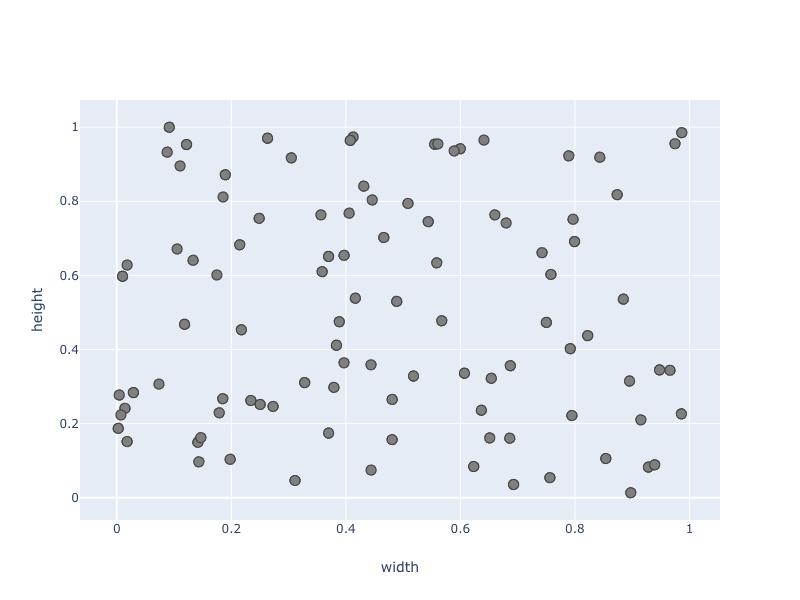

In [5]:
layout = dict(width=800, height=600, yaxis=dict(title_text="height"), xaxis=dict(title_text="width"))
plotter = Linear2D2ClassModelPlotter((0,1), (0,1), layout=layout)
plotter.update_data_plots(data)
plot_as_image(plotter())

### En lineær modell for boks-dataen

Er dette en god modell for boks-dataen vår?

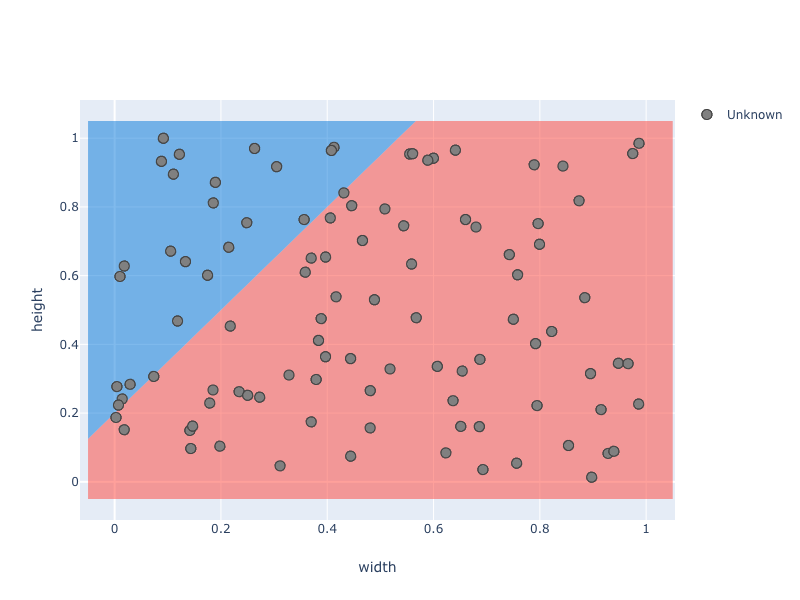

In [6]:
plotter.update_model_area_plots(lambda x: 1.5*x+0.2)
plot_as_image(plotter())

Umulig å vite. For å kunne en veiledet modell trenger vi noe som kan veilede modellen.

In [7]:
def predict(boolean_model, data, class_names):
    label_ids = boolean_model(data)
    label_names = np.asarray(class_names)
    return label_names[label_ids.astype(int)]

### Tagging av hvert datapunkt

- For å veilede modellen vår må hvert punkt tagges med en kategori eller tallverdi.
- Mange potensielle måter å tagge boks-datapunktene våre, men én mulighet er å skille mellom "vide" og "høye" rektangler
- Obs: dette er *ikke* et problem som bør løses med maskinlæring, men det lar seg fint gjøre om man har samlet data med disse taggene

<center> <img src="../images/rectangle-classes.png"  style="height:600px;width:auto;"/> </center>

Vi vil da få et datasett på følgende format:

In [8]:
class_names = ["Tall rectangle", "Wide rectangle"]
model = lambda data: data[:,0] > data[:,1]
labels = predict(model, data, class_names)
pd.DataFrame(np.asarray([*data.T, labels]).T, columns=("width", "height", "class")).head(5)

,width,height,class
0,0.8953460631629142,0.3148974329865626,Wide rectangle
1,0.41659168803512836,0.5384010647096859,Tall rectangle
2,0.9865365122598324,0.9851359496139936,Wide rectangle
3,0.2728945519354834,0.24632392960331118,Wide rectangle
4,0.41271962331326284,0.9735090708637028,Tall rectangle


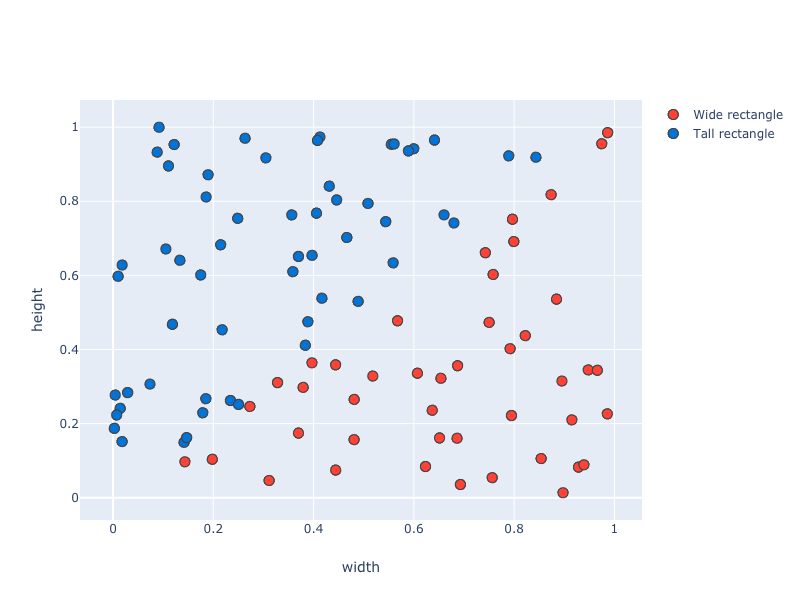

In [9]:
plotter.disable_model_areas()
plotter.update_data_plots(data, labels, unq_classes=class_names[::-1])
plot_as_image(plotter())

### En lineær modell for å skille mellom vide og høye rektangler

For å skille disse punktene fra hverandre kan vi trene en lineær modell vha veiledet læring. Kan vi nå si om modellen er god eller ikke?

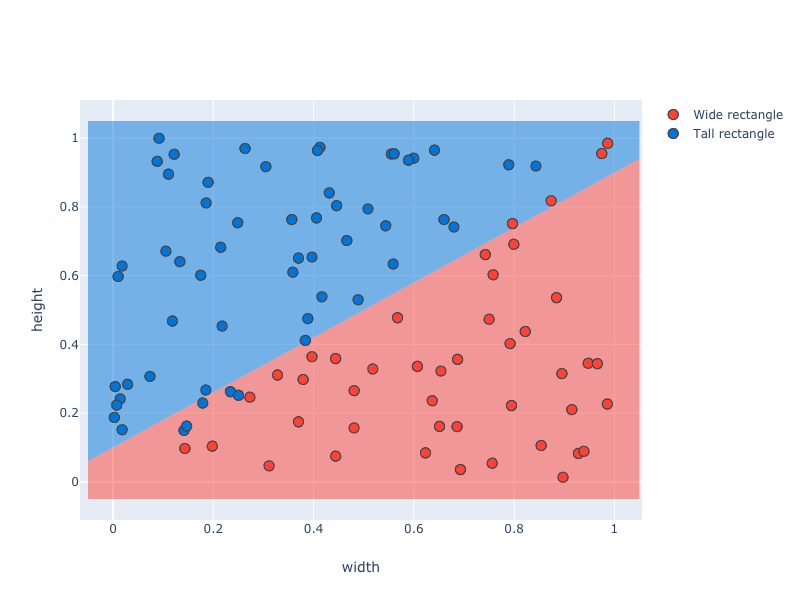

In [10]:
lin_model = lambda x: 0.8*x + 0.1
plotter.enable_model_areas()
plotter.update_model_area_plots(lin_model)
plot_as_image(plotter())

Ja, vi kan nå bruke kategoriene i datasettet vårt for å avgjøre om modellen er god eller om den må justeres.

Med en trent modell kan vi gjøre prediksjoner for nye datapunkter. Vi kan da "kaste vekk" all dataen vi brukte for å trene den.

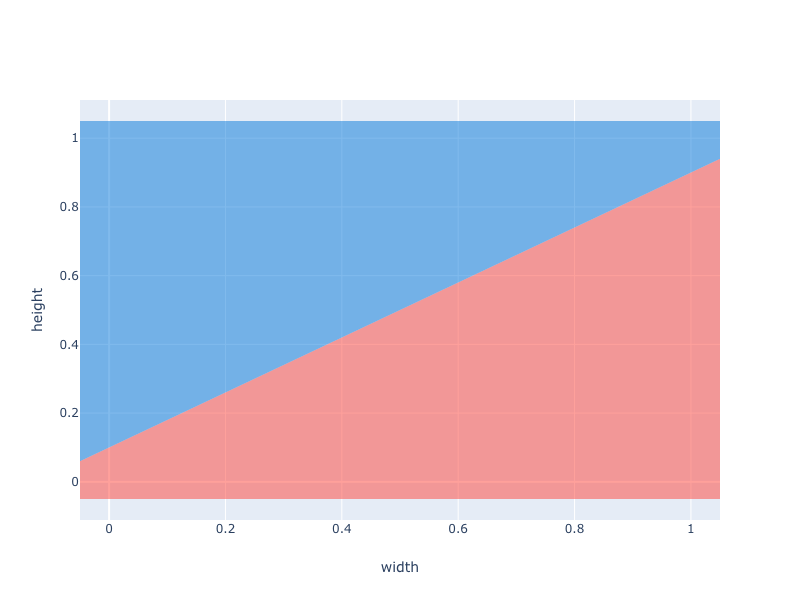

In [11]:
plotter.disable_data_points()
plot_as_image(plotter())

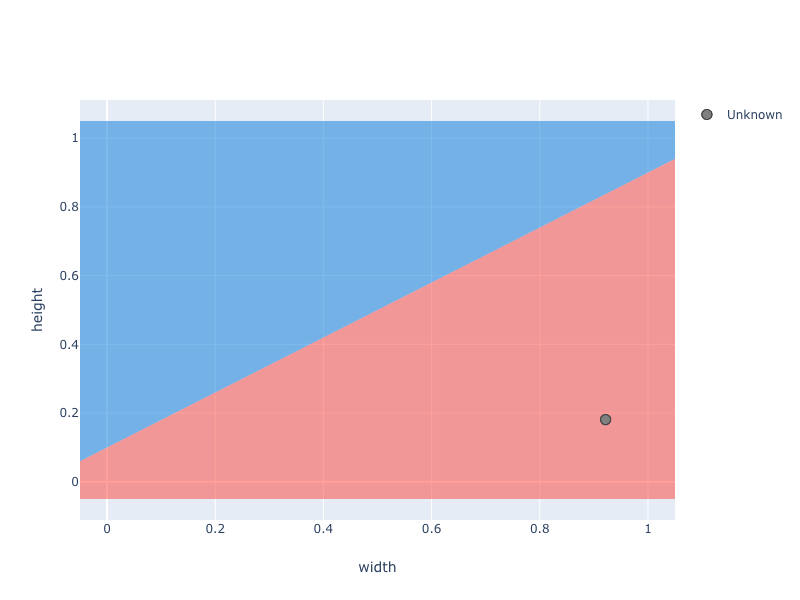

In [12]:
new_data = draw_uniform_data(1, (0,1), (0,1))
plotter.update_data_plots(new_data)
plotter.enable_data_points()
plot_as_image(plotter())

In [13]:
def predict_using_linear_model(lin_model, data, class_names):
    label_ids = (lin_model(data[:,0]) > data[:,1]).astype(int)
    return np.asarray(class_names)[label_ids]

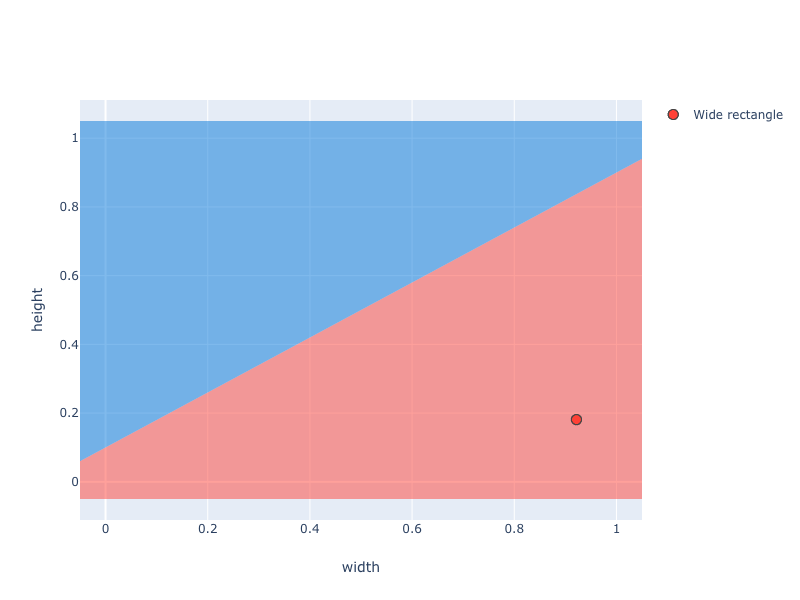

In [14]:
labels = predict_using_linear_model(lin_model, new_data, class_names)
plotter.update_data_plots(new_data, labels, unq_classes=class_names[::-1])
plot_as_image(plotter())

## Hvordan forbedre modellen?

For å finne ut hvordan modellen må endres kan vi definere en *feilfunkson* $E$ og bruke de deriverte av denne funksjonen mht parametere i modellen vår. Den deriverte for en parameter vil peke i retningen vi må endre parameteren for å redusere verdien av feilfunksjonen.

$$
\frac{\partial}{\partial w_i}E(modell, data, klasser)
$$
Hvor modellen er en funksjon av $w_0, w_1,...,w_n$

Link til presentasjon

### Psuedo-algoritme for veiledet læring ved "gradient descent" 

1. Start med en tilfeldig konfigurasjon av modellen
2. Beregn de deriverte (aka gradientene, derav "gradient descent")
3. Bruk disse for å oppdatere modellen
4. Iterer steg 1-3 frem til endringene av modellen fra et steg til det neste blir for små (eller et annet stopp-kriterium er nådd)

<center> <img src="../images/gradient-descent.jpg"/> </center>

La oss teste dette opp boks-dataen vår. Vi vet at den korrekte linjen for å skille høye og vide rektangler vil være:
$$y = w_0*x + w_1 = 1 * x + 0 = x$$

NB: Hvis animasjonen under ikke kommer opp, prøv å gå kjøre "File > Trust Notebook"

In [15]:
gradient_descent_animation((0, 1), (0, 1), w_real=[1, -1, 0], w_initial=[-0.5, -1, 0.8], lr=1, layout=layout, class_names=class_names, inv_class_names_for_plot=True)

# Ikke-veiledet læring

# Skaffe data

- Wikipedia
- Twitter
- Nyheter

# Wikiextractor

# BeautifulSoup

# Fra tekst til tall

- Alle maskinlæringsmodeller bruker matematikk/statistikk for å finne optimal konfigurasjon
- For å kunne bruke maskinlæring for NLP er vi derfor nødt til å konvertere tekstene til tall
- Mange måter å gjøre dette på:
    - Bag-of-words (BOW)
    - BOW + TF-IDF
    - N-grams (+ TF-IDF)
    - Char n-grams (+ TF-IDF)
    - Word embeddings (word2vec, Glove, fastText)
    - Document embeddings (doc2vec, min/max/mean pooling, RNN encoder)
    - Contextualized word embeddings (ELMO, BERT, Flair)

## Bag-of-words (BOW)

- Tell antall forekomster av hvert enkelt ord, og lag én kolonne per ord
- Hva er et ord? Standard definisjon er som regel "en sammenhengende sekvens av alfanumeriske (a-z, 0-9, _) karakterer"

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

texts = ["Dette er en tekst!", "håper dette funker :)"]
vec = CountVectorizer()
texts_vec = vec.fit_transform(texts)
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,dette,en,er,funker,håper,tekst
0,1,1,1,0,0,1
1,1,0,0,1,1,0


In [17]:
print(texts_vec)

  (0, 0)	1
  (0, 2)	1
  (0, 1)	1
  (0, 5)	1
  (1, 0)	1
  (1, 4)	1
  (1, 3)	1


Alternativt ord-mønster:

In [18]:
vec2 = CountVectorizer(token_pattern="(?:\w+|[^\w\s]+)")
texts_vec2 = vec2.fit_transform(texts)
pd.DataFrame(texts_vec2.todense(), columns=vec2.get_feature_names())

,!,:),dette,en,er,funker,håper,tekst
0,1,0,1,1,1,0,0,1
1,0,1,1,0,0,1,1,0


Tips:
- Jobber du med et domene du kjenner, eller domene-eksperter - bruk kunnskapen din til å forbedre ord-mønsteret ditt.
- F.eks. vil smileys muligens være nyttig å hente ut som egne ord om du bygger en sentiment-klassifiserer.

# "TF-IDF"-vekting av ord
- **TF** (Term frequency): Antall ganger ordet oppstår i en bestemt tekst
- **IDF** (Inverse document frequency): Antall ganger ordet oppstår i alle tekster
- Med TF-IDF vekter vi opp om de oppstår flere ganger i en tekst, og ned om de oppstår ofte i alle tekster
- Intuitivt: et ord som brukes flere ganger i en tekst er sannsynligvis viktig for denne teksten, men om det oppstår ofte i alle tekster er det sannsynligvis bare et vanlig ord i vokabularet og bør vektes ned

Med TF, uten IDF:

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
texts = ["Ha ha det var morsomt", "Det var veldig, veldig, veldig bra"]
vec3 = TfidfVectorizer(use_idf=False, norm=None)
texts_vec3 = vec3.fit_transform(texts)
pd.DataFrame(texts_vec3.todense(), columns=vec3.get_feature_names())

,bra,det,ha,morsomt,var,veldig
0,0.0,1.0,2.0,1.0,1.0,0.0
1,1.0,1.0,0.0,0.0,1.0,3.0


Med TF og IDF:

In [20]:
vec4 = TfidfVectorizer(use_idf=True, norm=None)
texts_vec4 = vec4.fit_transform(texts)
pd.DataFrame(texts_vec4.todense(), columns=vec4.get_feature_names())

,bra,det,ha,morsomt,var,veldig
0,0.000000,1.0,2.81093,1.405465,1.0,0.000000
1,1.405465,1.0,0.00000,0.000000,1.0,4.216395


# N-grams

- En naturlig utvidelse av bag-of-words er å se på uttrykk som består av mer enn ett ord, såkalte "n-gram"
    - F.eks. "New York", "Amazon Web Services"
- Mest brukt er såkalte *bigrams* og *trigrams*, som består av hhv. 2 og 3 etterfølgende ord. 
    - Man kan se på n-grams av større størrelse, men av erfaring er ofte bigrams nok, noen få ganger trigrams
- Den enkleste formen for generering av n-grams vil være å helt enkelt *generere alle mulige kombinasjoner av ord fra datasettet*

In [21]:
texts = ["Dette er en tekst!", "håper dette funker :)"]
vec = CountVectorizer(ngram_range=(1, 2))
texts_vec = vec.fit_transform(texts)
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,dette,dette er,dette funker,en,en tekst,er,er en,funker,håper,håper dette,tekst
0,1,1,0,1,1,1,1,0,0,0,1
1,1,0,1,0,0,0,0,1,1,1,0


Det er dessuten vanlig å kombinere n-grams med TF-IDF vekting:

In [22]:
texts = ["Dette er en tekst!", "håper dette funker :)"]
vec = TfidfVectorizer(ngram_range=(1, 2))
texts_vec = vec.fit_transform(texts)
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,dette,dette er,dette funker,en,en tekst,er,er en,funker,håper,håper dette,tekst
0,0.278943,0.392044,0.000000,0.392044,0.392044,0.392044,0.392044,0.000000,0.000000,0.000000,0.392044
1,0.335176,0.000000,0.471078,0.000000,0.000000,0.000000,0.000000,0.471078,0.471078,0.471078,0.000000


## Mer intelligent generering av bigrams 

In [23]:
vec = CountVectorizer(ngram_range=(1, 2))
texts_vec = vec.fit_transform(["Hei på deg. Dette er en test."])
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,deg,deg dette,dette,dette er,en,en test,er,er en,hei,hei på,på,på deg,test
0,1,1,1,1,1,1,1,1,1,1,1,1,1


- Legg merke til kolonne 2 "deg dette". Her har vi fått generert et uttrykk på tvers av setninger. Vi vet at det aldri skal skje. Vi bør splitte tekstene i setninger for mer fornuftig generering av n-grams.
- Vi er dessuten ikke interessert i alle mulige kombinasjoner, kun de som (sannsynligvis) er faktiske uttrykk

## Splitting av setninger

- Å splitte setninger er ikke så enkelt som å bare splitte på punktum, da vil man f.eks. feil ved forkortelser.
- Heldigvis er dette et vanlig problem, og det finnes flere pakker med funksjonalitet for å gjøre dette - også for norsk.

In [24]:
def print_sents(sents):
    for i, sent in enumerate(sents):
        print(f"Sentence {i+1}:", repr(str(sent)))

Spacy har delvis støtte for norsk. Splitting av setinger er blant annet støttet:

In [25]:
from spacy.lang.nb import Norwegian
sent_pipeline = Norwegian()
sentencizer = sent_pipeline.create_pipe("sentencizer")
sent_pipeline.add_pipe(sentencizer)
doc = sent_pipeline("Dette er en test. Funker dette? Her har vi f.eks. en forkortelse. Dr. Dre var ")
print_sents(doc.sents)

Sentence 1: 'Dette er en test.'
Sentence 2: 'Funker dette?'
Sentence 3: 'Her har vi f.eks. en forkortelse.'
Sentence 4: 'Dr.'
Sentence 5: 'Dre var'


Polyglot har også full støtte for norsk:

In [26]:
# from polyglot.text import Text
# doc = Text("Dette er en test. Funker dette? Her har vi f.eks. en forkortelse.", hint_language_code="nb")
# print_sents(doc.sentences)

Hva med ekte data?

In [27]:
df = load_diskusjon_no_data(-1)
text = df.body.iloc[1]
print(text)

Vær snill å lese de nye retningslinjene før du poster i loggkategoriene. Den viktigste endringen er:

Plassering
Loggområdet er delt i Arbeidslogger og Arbeidslogger - Kommentarer.
- "Arbeidslogger" en kategorien hvor arbeidsloggen skal føres. Kun de som deltar i prosjektet (som oftest trådstarter) skal poste i denne tråden.
- "Arbeidslogger - Kommentarer" er en kategori hvor du skal opprette en tråd med samme tittel som den du opprettet i "Arbeidslogger", slik at andre kan kommentere ditt arbeide. Her kan alle svare.

Bilder fra loggen skal ikke legges i kommentartråden. Fra første post i kommentartråden linker du til arbeidsloggen, kanskje med et lite bilde.

Alle de gamle trådene er flyttet til " Arbeidslogger - Kommentarer". Trådstarere må gjerne opprette arbeidslogger i "Arbeidslogger" med basis i den gamle tråden (som nå vil fungere som kommentartråd.


In [28]:
doc = sent_pipeline(text)
print_sents(doc.sents)

Sentence 1: 'Vær snill å lese de nye retningslinjene før du poster i loggkategoriene.'
Sentence 2: 'Den viktigste endringen er:\n\nPlassering\nLoggområdet er delt i Arbeidslogger og Arbeidslogger - Kommentarer.'
Sentence 3: '\n- "Arbeidslogger" en kategorien hvor arbeidsloggen skal føres.'
Sentence 4: 'Kun de som deltar i prosjektet (som oftest trådstarter) skal poste i denne tråden.'
Sentence 5: '\n- "Arbeidslogger - Kommentarer" er en kategori hvor du skal opprette en tråd med samme tittel som den du opprettet i "Arbeidslogger", slik at andre kan kommentere ditt arbeide.'
Sentence 6: 'Her kan alle svare.'
Sentence 7: '\n\nBilder fra loggen skal ikke legges i kommentartråden.'
Sentence 8: 'Fra første post i kommentartråden linker du til arbeidsloggen, kanskje med et lite bilde.'
Sentence 9: '\n\nAlle de gamle trådene er flyttet til " Arbeidslogger - Kommentarer".'
Sentence 10: 'Trådstarere må gjerne opprette arbeidslogger i "Arbeidslogger" med basis i den gamle tråden (som nå vil fung

La oss splitte alle postene fra diskusjon.no i setninger. Vi antar at alle post-titler allerede er splittet, så vi dropper å splitte disse.

In [29]:
%%time
def _split_into_sentences(text):
    doc = sent_pipeline(text)
    return [str(sent).strip() for sent in doc.sents]

body_sents = process(_split_into_sentences, df.body)

CPU times: user 249 ms, sys: 67.3 ms, total: 316 ms
Wall time: 8.09 s


## Generering av bigrams fra setningene

In [30]:
all_sents = df.title.tolist() + [s for sentences in body_sents for s in sentences]

In [31]:
len(all_sents)

136643

In [32]:
from gensim.models.phrases import Phrases, Phraser
from spacy.lang.nb.stop_words import STOP_WORDS

tokenize = lambda sent: [word.lower() for word in re.findall(r"\w+", sent)]
all_sents_tokens = [tokenize(s) for s in all_sents]
phrases = Phrases(all_sents_tokens, min_count=3, threshold=1, common_terms=STOP_WORDS)
bigram = Phraser(phrases)

In [33]:
bigram[tokenize("Jeg har windows 10 på min gaming pc")]

['jeg', 'har', 'windows_10', 'på', 'min', 'gaming_pc']

La oss se på de mest vanlige bigramene i tekstene våre:

In [34]:
from collections import Counter

def count_ngrams(phraser, sentences, n=None):
    ngrams_counter = Counter()
    for sent in sentences:
        phrases = phraser[sent]
        tokens = [token for token in phrases if _is_ngram(token, n)]            
        ngrams_counter.update(tokens)
    return ngrams_counter

def _is_ngram(token, n):
    if "_" not in token:
        return False
    if n is None:
        return True
    words = token.split("_")
    return len([w for w in words if w not in STOP_WORDS]) == n


def print_most_common(counter, n):
    for key, count in counter.most_common(n):
        print(f"{key:<20} {count}")

In [35]:
bigrams_counter = count_ngrams(bigram, all_sents_tokens)

Merk at vi vil ha fraser med mer enn to ord, fordi såkalte "stopwords" ikke teller med i antall ord for n-gramet når vi bruker denne algoritmen

In [36]:
print_most_common(bigrams_counter, 30)

https_www            1292
http_www             932
f_eks                837
rett_og_slett        283
diskusjon_no         246
of_the               227
forhånd_takk         221
1_2                  211
windows_10           205
in_the               171
takk_for_svar        166
trenger_hjelp        157
takk_på_forhånd      150
setter_pris          148
anonymous_poster     144
blu_ray              142
2_3                  142
3_5                  137
3_4                  136
finn_no              125
o_l                  122
apple_tv             119
myspace_offisiell    106
canal_digital        105
5_1                  104
2_5                  100
bl_a                 98
1_1                  98
samsung_galaxy       97
tusen_takk           97


## Fra bigrams til trigrams og videre

For å generere trigrams kan vi kjøre samme algoritme som over, rekursivt:

In [37]:
all_sents_bigrams = bigram[all_sents_tokens]
trigram = Phrases(all_sents_bigrams, min_count=3, threshold=1, common_terms=STOP_WORDS)
trigram = Phraser(trigram)

In [38]:
trigrams_counter = count_ngrams(trigram, all_sents_bigrams, n=3)

In [39]:
print_most_common(trigrams_counter, 30)

https_www_komplett   136
anonymous_poster_hash 129
myspace_offisiell_hjemmeside 101
karakter_10_10       56
per_dags_dato        42
karakter_9_10        39
https_www_youtube    37
karakter_8_10        32
lars_von_trier       30
anders_behring_breivik 27
https_www_diskusjo   27
forhånd_takk_for_svar 27
juni_18_00           27
com_http_www         26
https_prisguiden_n   25
karakter_7_10        24
rock_n_roll          24
blu_ray_spiller      21
fritt_til_å_tolke_temaet 21
galleriet_på_akam_no 21
karakter_6_10        21
usb_2_0              20
m_2_ssd              20
f_2_8                19
samarbeider_med_diskusjon_no 19
sporliste_min_mening 19
ipb3_0_oppgr         18
takk_for_all_hjelp   18
forhånd_tusen_takk   18
usb_3_0              17


## En "transformer" for smarte bigrams

For å kunne bruke smarte bigrams, trigrams osv. i en modell er vi nødt til å lage et objekt med tilsvarende API som CountVectorizer. Vi kan gjøre dette ved å modifisere noen av koden til denne klassen. For å se hvordan koden er modifisert, gå til ```nlp_intro.gensim_ngram_vectorizer```.

In [40]:
import numpy as np
from scipy.sparse import find

def transform_with_vec(text, vec):
    assert isinstance(text, str)
    text_vec = vec.transform([text])[0]
    _, ix, values = find(text_vec)
    feats = np.asarray(vec.get_feature_names())
    return pd.DataFrame([values], columns=feats[ix])

Normale n-grams:

In [41]:
%%time
text = "Jeg har windows 10 på min gaming pc"
vec1 = CountVectorizer(ngram_range=(1,2))
vec1.fit(df.body)
transform_with_vec(text, vec1)

CPU times: user 7 s, sys: 323 ms, total: 7.32 s
Wall time: 7.33 s


,10,10 på,gaming,gaming pc,har,har windows,jeg,jeg har,min,pc,på,på min,windows,windows 10
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1


"Smarte" n-grams:

In [42]:
%%time
from nlp_intro.gensim_ngram_vectorizers import NgramCountVectorizer
vec2 = NgramCountVectorizer(ngram_range=(1,2), phrases_common_terms=STOP_WORDS)
vec2.fit(df.body)
transform_with_vec(text, vec2)

CPU times: user 23.4 s, sys: 533 ms, total: 23.9 s
Wall time: 33.6 s


,10,gaming,gaming_pc,har,jeg,min,pc,på,windows,windows_10
0,1,1,1,1,1,1,1,1,1,1


Mer at prosesseringen tar mye lengre tid, fordi vi både må splitte tekstene i setninger, og gjøre beregninger for å finne bigrams. Bigramene vi får er derimot bedre.

# Char n-grams

- Skandinaviske språk som Norsk har mange sammensatte ord
- Med sammensatte ord får vi veldig mange unike kombinasjoner av ord, som kun brukes et fåtall ganger
- En kjapp test på vokabularet fra norske Wikipedia viste at **50% av alle unike ord kun hadde blitt brukt 1 gang** (!)
- Om vi bruker ord som features kan derfor maskinlæring noen ganger bli vanskelig

In [93]:
from scipy.sparse import issparse

def vec_similarity(vec1, vec2):
    if issparse(vec1):
        vec1 = _sparse_to_1d(vec1)
    if issparse(vec2):
        vec2 = _sparse_to_1d(vec2)
    vec1, vec2 = vec1 / np.linalg.norm(vec1), vec2 / np.linalg.norm(vec2)
    sim = vec1.dot(vec2.T)
    print(f"Similarity: {sim*100:.2f}%")
    
def _sparse_to_1d(vec):
    return np.asarray(vec.todense()).squeeze() 

In [94]:
vec = CountVectorizer()
texts = ["språkprossesering", "prosessering av språk"]
texts_vec = vec.fit_transform(texts)
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,av,prosessering,språk,språkprossesering
0,0,0,0,1
1,1,1,1,0


In [95]:
vec_similarity(texts_vec[0], texts_vec[1])

Similarity: 0.00%


Ikke bra

I naturlige tekster har vi også ofte skrivefiel:

In [96]:
vec = CountVectorizer()
texts = ["språkprossesering", "språkprosesering"]
texts_vec = vec.fit_transform(texts)
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,språkprosesering,språkprossesering
0,0,1
1,1,0


In [97]:
vec_similarity(texts_vec[0], texts_vec[1])

Similarity: 0.00%


Et alternativ til ord-baserte n-grams er å bruke karakter-baserte n-grams. Vi ønsker da å hente ut alle *sammenhengende sekvenser av bokstaver* fra tekstene:

In [98]:
vec = CountVectorizer(analyzer="char", ngram_range=(4,4))
texts = ["språkprossesering", "prosessering av språk"]
texts_vec = vec.fit_transform(texts)
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,av,spr,av s,erin,eser,esse,g av,ing,kpro,ng a,...,ross,råkp,seri,sese,sess,språ,sser,sses,v sp,åkpr
0,0,0,0,1,1,0,0,0,1,0,...,1,1,1,1,0,1,0,1,0,1
1,1,1,1,1,0,1,1,1,0,1,...,0,0,1,0,1,1,1,0,1,0


In [99]:
vec_similarity(texts_vec[0], texts_vec[1])

Similarity: 37.80%


In [100]:
texts = ["språkprossesering", "språkprosesering"]
texts_vec = vec.fit_transform(texts)
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,erin,eser,kpro,oses,osse,pros,pråk,ring,rose,ross,råkp,seri,sese,språ,sses,åkpr
0,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1
1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,0,1


In [101]:
vec_similarity(texts_vec[0], texts_vec[1])

Similarity: 81.54%


## Char n-grams, tips:

- En lengde på 4 funker ofte (av erfaring) bra for char n-grams. Det er et godt midtpunkt mellom:
    - For korte sekvenser, som gjør at "alle" ord vil matche
    - For lange sekvenser, som i praksis vil gi samme resultat som ord-baserte n-grams
- Du kan bytte analyzer til ```char_wb```, som vil si at du kun bruker n-grams innenfor hvert ord, ikke på tvers
- Vær obs på at det du har satt som ```token_pattern``` ignoreres når du bruker char n-grams. Dvs. selv om du setter et token pattern som matcher kun bokstaver, vil char n-grams også inneholde tegnsetting:

"Token pattern" ignoreres for char n-grams:

In [52]:
vec = CountVectorizer(analyzer="char", ngram_range=(4,4), token_pattern="\w+")
text = "Hei, John!"
texts_vec = vec.fit_transform([text])
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,joh,", jo","ei,","hei,","i, j",john,ohn!
0,1,1,1,1,1,1,1


# Word embeddings

- Måten vi hittil har konvertert tekst til tall, kalles ofte en glissen (en: sparse) representasjon av tekst, fordi hvert enkelt ord kun er representert av én verdi i en glissen matrise. 
- Alle ord vil derfor ha samme "likhet"/"forskjellighet"

Samme likhet/forskjellighet for alle ord:

In [102]:
vec = CountVectorizer()
texts = ["Hund", "Katt", "Skrutrekker"]
texts_vec = vec.fit_transform(texts)
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,hund,katt,skrutrekker
0,1,0,0
1,0,1,0
2,0,0,1


Likhet mellom vektoren for hund og katt:

In [103]:
vec_similarity(texts_vec[0], texts_vec[1])

Similarity: 0.00%


Likhet mellom vektoren for hund og skrutrekker:

In [104]:
vec_similarity(texts_vec[0], texts_vec[2])

Similarity: 0.00%


Det hadde vært fint om vi kunne representert ord på en annen måte, slik at ```likhet(hund, katt)``` > ```likhet(hund, skrutrekker)```

## Word Embeddings - læring av "substitutter"

- "Word embeddings" er en tett (en: dense) måte å representere ord på, fordi vi har 'mverdier i alle kolonner for ordet. F.eks.
vil vektoren for hun være noe som ```[0.1231, 1.3030, 3.2233, ...]```
- Hver kolonne i en WE vektor vill representere en egenskap ved ordet, slik at ord som kan være substitutter for hverandre vil være "nærmere" hverandre
- Maskinlæringsproblemet vi løser for å finne disse vektorene er av typen:
    - Gitt et ord - prediker konteksten til ordet (Skip-gram)
    - Gitt konteksten til odet - prediker ordet (CBOW)

## Skip-gram

Figurer hentet fra: http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/

(som forøvrig er en mer detaljert gjennomgang av temaet)

<center> <img src="../images/skip-gram-1.png"/> </center>

<center> <img src="../images/skip-gram-2.png"/> </center>

## Hvordan få tilgang til "word embeddings"

For å bruke "word embeddings", kan vi enten:
1. Trene dem selv på et passende sett med dokumenter (gjerne et stort sett, dvs. mange ord)
2. Laste ned forhåndstrente modeller og bruke disse

NB: hvilket datasett word embeddigene er trent på har mye å si for hvordan embeddingene ender opp. Ord som er like i ett vokabular kan være helt ulike i et annet, om kontreksten de brukes i er ulik.

## Word2Vec word embeddings 

Vi velger her å laste ned en forhåndstrent modell fra http://vectors.nlpl.eu/repository/. Modellen vi bruker er for bokmål og trent på norske tekster fra [CoNLL 17](http://universaldependencies.org/conll17/):

In [56]:
from gensim.models import KeyedVectors

Vi ignorerer unicode feil ved innlasting av modellen, fordi det kan få hele innlastingen til å feile. Se https://github.com/RaRe-Technologies/gensim/wiki/Recipes-&-FAQ#q10-loading-a-word2vec-model-fails-with-unicodedecodeerror-utf-8-codec-cant-decode-bytes-in-position-

In [74]:
w2v_model = KeyedVectors.load_word2vec_format("../resources/embeddings/model.bin", unicode_errors='ignore', binary=True, encoding="utf8")

La oss bli litt bedre kjent med modellen:

In [76]:
w2v_model["hund"].shape

(100,)

In [77]:
w2v_model["hund"][:10]

array([ 4.160294  , -0.7913837 , -4.759459  ,  1.3926575 ,  1.1881433 ,
        4.7561536 ,  1.5202963 , -0.87461686,  2.760311  , -0.37462923],
      dtype=float32)

- Vi ser altså at vi har 100 ulike ikke-null verdier som beskriver ordet "hund"
- Hva disse verdiene er bryr vi oss ikke om - vi er bare interessert i at like ord har like embeddings

Nå som hvert ord har mange ulike "features" kan vi sammenligne dem:

In [78]:
w2v_model.most_similar("hund", topn=5)

[('katt', 0.8834836483001709),
 ('hest', 0.8537960052490234),
 ('hunden', 0.8209482431411743),
 ('valp', 0.8072998523712158),
 ('kanin', 0.8040313124656677)]

In [79]:
w2v_model.most_similar("skrutrekker", topn=5)

[('skiftenøkkel', 0.9227230548858643),
 ('avbitertang', 0.8999788761138916),
 ('brødkniv', 0.8843042254447937),
 ('tapetkniv', 0.8789403438568115),
 ('vinkelsliper', 0.8771433234214783)]

La oss nå bekrefte at vi har en representasjon hvor ```likhet(hund, katt)``` > ```likhet(hund, skrutrekker)```:

In [108]:
print("Hund og katt, ", end="")
vec_similarity(w2v_model["hund"], w2v_model["katt"])
print("Hund og skrutrekker, ", end="")
vec_similarity(w2v_model["hund"], w2v_model["skrutrekker"])

Hund og katt, Similarity: 88.35%
Hund og skrutrekker, Similarity: 48.94%


## Vektor-matematikk på ordene

<center> <img src="../images/word-emb-math.png"/> </center>

burger - amerika + italia:

In [145]:
w2v_model.most_similar(positive=["burger", "italia"], negative=["amerika"], topn=1)

[('pizza', 0.7512732744216919)]

Hva med ord som ikke finnes i vokabularet?

In [149]:
try:
    w2v_model["k34oi3kio4"]
except Exception as e:
    print(f"{type(e).__name__}: {str(e)}")

KeyError: "word 'k34oi3kio4' not in vocabulary"


# FastText word embeddings

Modellen vi har brukt for word embeddings så langt har brukt fullstendig ord som *tokens* i modellen. Dette byr på problemer for sammensatte ord:

In [152]:
vec_similarity(w2v_model["språkprosessering"], w2v_model["språk"] + w2v_model["prosessering"])

Similarity: 14.77%


*FastText* er en annen måte å genrerere word embeddings, som tar del-ord med i målfunksjonen når modellen optimeres.

Vi bruker her en modell forhåndstrent av Facebook (som har designet FastText): https://fasttext.cc/docs/en/crawl-vectors.html.på. Modellen vi bruker er for bokmål og trent på norske tekster fra data fra Wikipedia:

**Obs**: Modellen er ganske stor, så om du har lite minne på maskinen din, ikke last inn ```ft_model```.

In [161]:
from gensim.models.wrappers import FastText

In [174]:
ft_model = FastText.load_fasttext_format("../resources/embeddings/cc.no.300.bin")

Merk at modellen er mye større enn den for word2vec, både fordi vi har flere ord (vi har jo også del-ord), men også fordi hver vektor har 300 dimensjoner vs. 100 for W2V-modellen vi brukte tidligere

La oss undersøke hvordan denne modellen er annerledes:

In [177]:
ft_model["hund"].shape

(300,)

In [181]:
ft_model.most_similar("hund", topn=5)

[('hunden', 0.7746080160140991),
 ('løshund', 0.768308162689209),
 ('gråhund', 0.7630655765533447),
 ('hunder', 0.7626408338546753),
 ('hihund', 0.7605112195014954)]

In [182]:
w2v_model.most_similar("hund", topn=5)

[('katt', 0.8834836483001709),
 ('hest', 0.8537960052490234),
 ('hunden', 0.8209482431411743),
 ('valp', 0.8072998523712158),
 ('kanin', 0.8040313124656677)]

Ord som inneholder hund, er altså nærmere i vektor-rommet når vi bruker FastText embeddings.

Hva med vektormatte?

In [189]:
ft_model.most_similar(positive=["språk", "prosessering"])

[('språkprosessering', 0.5796246528625488),
 ('Prosessering', 0.5429927706718445),
 ('informasjonsprosessering', 0.5236091613769531),
 ('prosesseringen', 0.5149697065353394),
 ('språket', 0.50953209400177),
 ('oversetting', 0.49858883023262024),
 ('geoprosessering', 0.49221867322921753),
 ('reprosessering', 0.49008405208587646),
 ('dataprosessering', 0.4815547466278076),
 ('annotering', 0.4805752635002136)]

Og hva med ord som ikke finnes fra før i vokabularet?

In [196]:
"Bouvethuset" in ft_model.wv.vocab

False

In [199]:
ft_model["Bouvethuset"][:10]

array([-0.00424563, -0.01575789,  0.00175956,  0.00907038,  0.01062388,
       -0.00300563,  0.00662526,  0.00761305, -0.02929272,  0.00666009],
      dtype=float32)

Funker uten å kaste en feil!

In [201]:
ft_model.similar_by_vector(ft_model["Bouvethuset"], topn=5)

[('Bouvetoya', 0.7346912622451782),
 ('Bouvetøy', 0.7313781976699829),
 ('Giethuset', 0.6989498734474182),
 ('Kulthuset', 0.6714847087860107),
 ('Elkemhuset', 0.6714712381362915)]

## Greit å vite om word embeddings

- Like ord er *ikke synonymer*. F.eks. kan ordet *glad* og *trist* ha relativt like word embeddings, fordi de brukes i samme kontekst.
- FastText funker ofte bra for norsk, og andre språk som bruker mye sammensatte ord (f.eks. tysk), av samme grunn som at char n-grams funker bra
- Vi har kun én embedding per ord, så ord med flere betydninger avhengig av kontekst kan få litt rare embeddings

In [203]:
"Bouvethuset" in ft_model

True

# Fra ord til dokumenter

- Merk at word embeddings genererer en vektor for hvert ord, men ikke direkte kan brukes for å transformere en hel tekt til tall

In [ ]:
# Fasttext no: https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.no.300.bin.gz
# Word2vec: http://vectors.nlpl.eu/repository/11/77.zip

# Tips
- Generelt, desto mindre data du har, desto viktigere er det å hjelpe modellen med litt menenskelig kunskap ved å prosessere dataen på en måte vi vet gir mening

In [ ]:
class A:
    def __init__(self, param):
        self.param = param
    def foo(self):
        print(self.param)
        
class B:
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        pass
    
    def foo(self):
        print("hey")
        super().foo()
        
class C(B, A):
    pass

c = C("man")
c.foo()

# Andre ressurser

In [ ]:
import spacy
nb_core = spacy.load("nb_core_news_sm")